<a href="https://colab.research.google.com/github/flaviorv/pb_ai_ml/blob/main/Copy_of_pb_tp4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

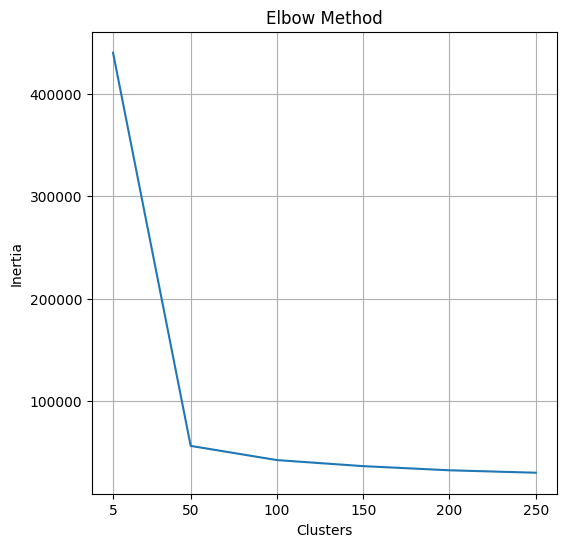

In [102]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.feature_extraction import FeatureHasher
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt

# loading the dataset
df = pd.read_csv('https://raw.githubusercontent.com/flaviorv/pb_ai_ml/refs/heads/main/datasets/spotify.csv')

# dropping irrelevant features
df.dropna(inplace=True)
df.drop(['Unnamed: 0', 'track_id'], axis=1, inplace=True)

# splitting between target and features
y = df.pop('explicit').astype(int)
x = df

# splitting between training and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35, stratify=y, random_state=42)

# balancing the classes of train data
rus = RandomUnderSampler(random_state=42)
x_train, y_train = rus.fit_resample(x_train, y_train)

# separating features for scaling and encoding as needed
cat = ['key', 'time_signature', 'track_genre']
many_classes = ['artists', 'track_name', 'album_name']
cont = [
  'popularity', 'duration_ms', 'danceability',
  'energy', 'loudness', 'speechiness', 'acousticness',
  'instrumentalness', 'liveness','valence', 'tempo'
]

# using k-means to create a new feature
# the k-menas will be used only in the continuous vars

# using min max escaler to continuous vars
kmeans_preprocessor = ColumnTransformer(
  transformers=[
    ('rs', RobustScaler(), cont),
  ]
)

# finding the best n clusters of k-means to create a new feature
n_clusters = [5, 50, 100, 150, 200, 250]

# train/test features (encoded and scaled)
sx_train = kmeans_preprocessor.fit_transform(x_train)
sx_test = kmeans_preprocessor.transform(x_test)

# getting train data inertia
inertias = []
for i, k in enumerate(n_clusters):
  k_means = KMeans(n_clusters=k, random_state=42)
  train_clusters = k_means.fit_predict(sx_train)
  # saving the results
  inertias.append(k_means.inertia_)

# ploting the elbow method
plt.figure(figsize=(6,6))
plt.plot(n_clusters, inertias)
plt.xticks(n_clusters)
plt.ylabel('Inertia')
plt.xlabel('Clusters')
plt.grid(True)
plt.title('Elbow Method')
plt.show()

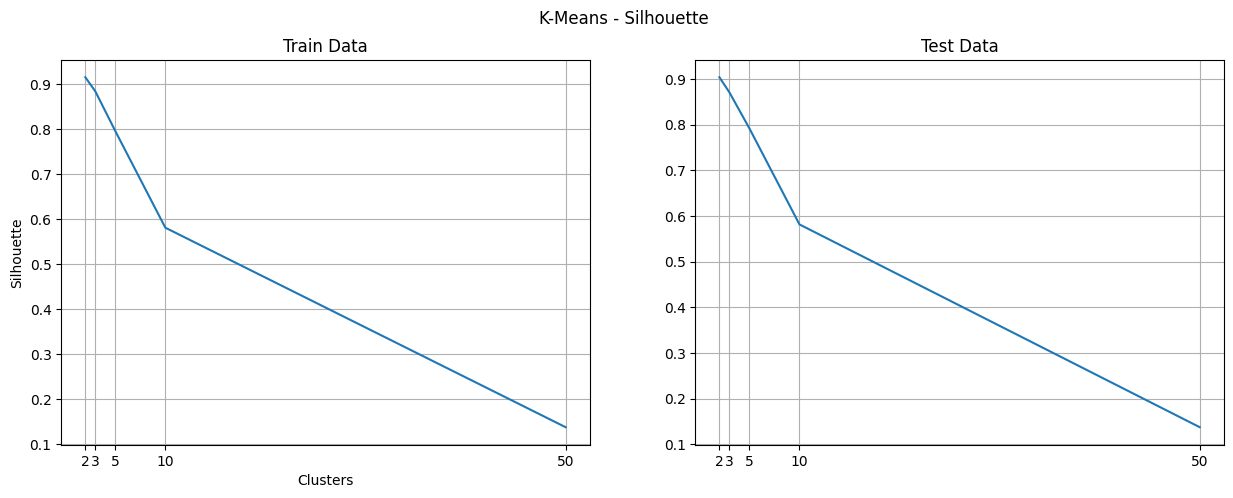

In [106]:
# refining the hyperparametric search
n_clusters = [2, 3, 5, 10, 50]
silhouettes_train = []
silhouettes_test = []
metrics = {}
for k in n_clusters:
  k_means = KMeans(n_clusters=k, random_state=42)
  train_clusters = k_means.fit_predict(sx_train)
  test_clusters = k_means.predict(sx_test)
  # saving the results
  silhouettes_train.append(silhouette_score(sx_train, train_clusters))
  silhouettes_test.append(silhouette_score(sx_test, test_clusters))

# ploting the silhouette metrics
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
ax[0].plot(n_clusters, silhouettes_train)
ax[0].set_xticks(n_clusters)
ax[0].set_title('Train Data')
ax[1].plot(n_clusters, silhouettes_test)
ax[1].set_xticks(n_clusters)
ax[1].set_title('Test Data')
ax[0].set_ylabel('Silhouette')
ax[0].set_xlabel('Clusters')
ax[0].grid(True)
ax[1].grid(True)
plt.suptitle('K-Means - Silhouette')
plt.show()

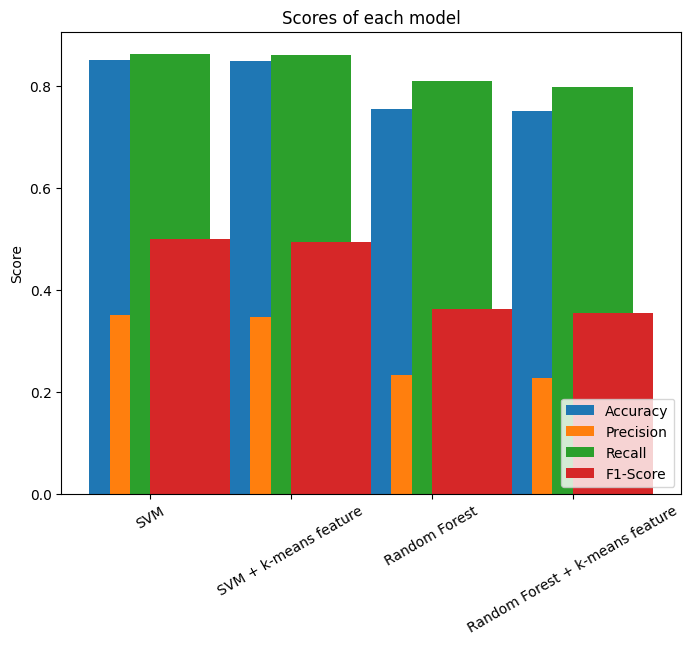

In [108]:
# using the best n clusters to create the feature
k_means = KMeans(n_clusters=2)
c_train = k_means.fit_predict(sx_train)
c_test = k_means.predict(sx_test)

# converting from ndarray to dataframe
labels_train = pd.DataFrame(c_train, columns=['cluster'], index=x_train.index)
labels_test = pd.DataFrame(c_test, columns=['cluster'], index=x_test.index)

# creating train and test data with the new feature
cx_train = pd.concat([x_train, labels_train], axis=1)
cx_test = pd.concat((x_test, labels_test), axis=1)

# transform the categorical features that have too many classes in a dict and making the hashing trick
class HashingWrapper(BaseEstimator, TransformerMixin):
  def __init__(self, n_features=2000, dtype=float):
    self.n_features = n_features
    self.dtype = dtype
    self.hasher = FeatureHasher(n_features=self.n_features, input_type='dict', dtype=self.dtype)

  def fit(self, x, y=None):
    return self

  def transform(self, x):
    x = x.to_dict(orient="records")
    return self.hasher.transform(x)

# transform each dataframe x column separately
preprocessor = ColumnTransformer(transformers=[
  ('min_max', MinMaxScaler(), cont),
  ('one_hot', OneHotEncoder(handle_unknown='ignore'), cat),
  ('hashing_trick', HashingWrapper(), many_classes)
], remainder='passthrough')

# automating steps
pipeline = Pipeline(steps=[
  ('scalers', preprocessor),
  ('model', DummyClassifier())
])

# SVM hyperparams
svm_params = [
  {
    'model': [SVC(random_state=42, probability=True)],
    'model__kernel': ['linear'],
    'model__C': [0.01, 0.1, 1],
  },
  {
    'model': [SVC(random_state=42, probability=True)],
    'model__kernel': ['rbf', 'poly'],
    'model__C': [0.01, 0.1, 1],
    'model__gamma': [0.01, 1, 2]
  },
]

# Random Forest hyperparams
rf_params = [
  {
    'model': [RandomForestClassifier(random_state=42)],
    'model__n_estimators': [30, 50, 100, 300],
    'model__max_depth': [3, 5, 10, 15, 30, 40],
    'model__min_samples_split': [2, 4, 8, 12],
    'model__min_samples_leaf': [1, 5, 10],
    'model__max_leaf_nodes': [10, 20, 30, 50, None],
    'model__criterion': ['gini', 'entropy', 'log_loss']
  }
]

# max iteration of grid and the number of cross-validation folds
n_iter = 10
cv = 2

# grid searches to find the best hyperparams
svm_grid = RandomizedSearchCV(pipeline, svm_params, n_iter=n_iter, cv=cv, n_jobs=-1, random_state=42)
svm_grid.fit(x_train, y_train)
svm_pred = svm_grid.predict(x_test)

rf_grid = RandomizedSearchCV(pipeline, rf_params, n_iter=n_iter, cv=cv, n_jobs=-1, random_state=42)
rf_grid.fit(x_train, y_train)
rf_pred = rf_grid.predict(x_test)

# adding the new feature
cat2 = cat.copy()
cat2.append('cluster')

# scaling with the new feature
preprocessor2 = ColumnTransformer(
  transformers=[
    ('one_hot', OneHotEncoder(handle_unknown='ignore'), cat2),
    ('min_max', MinMaxScaler(), cont),
    ('hashing_trick', HashingWrapper(), many_classes)
  ], remainder='passthrough'
)

# automating steps
pipeline2 = Pipeline(steps=[
  ('scalers', preprocessor2),
  ('model', DummyClassifier())
])

# grid searches with the new feature
svm_grid2 = RandomizedSearchCV(pipeline2, svm_params, n_iter=n_iter, cv=cv, n_jobs=-1, random_state=42)
svm_grid2.fit(cx_train, y_train)
svm_pred2 = svm_grid2.predict(cx_test)

rf_grid2 = RandomizedSearchCV(pipeline2, rf_params, n_iter=n_iter, cv=cv, n_jobs=-1, random_state=42)
rf_grid2.fit(cx_train, y_train)
rf_pred2 = rf_grid2.predict(cx_test)

# plotting results of each model
groups = ['SVM', 'SVM + k-means feature', 'Random Forest', 'Random Forest + k-means feature']
preds = [svm_pred, svm_pred2, rf_pred, rf_pred2]

accuracy = []
precision = []
recall = []
f1 = []

for pred in preds:
  results = classification_report(y_test, pred, output_dict=True)
  accuracy.append(results['accuracy'])
  precision.append(results['1']['precision'])
  recall.append(results['1']['recall'])
  f1.append(results['1']['f1-score'])

n_groups = len(groups)
n_bars = 4
bar_width = 0.2
group_spacing = 0.6

x = np.arange((n_groups)) * (n_bars * bar_width + group_spacing)

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x, accuracy, label='Accuracy')
ax.bar(x + bar_width, precision, label='Precision')
ax.bar(x + 2*bar_width, recall, label='Recall')
ax.bar(x + 3*bar_width, f1, label='F1-Score')
plt.legend(loc='lower right')
ax.set_xticks(x + bar_width)
ax.set_xticklabels(groups, rotation=30)
ax.set_ylabel('Score')
ax.set_title('Scores of each model')
plt.show()

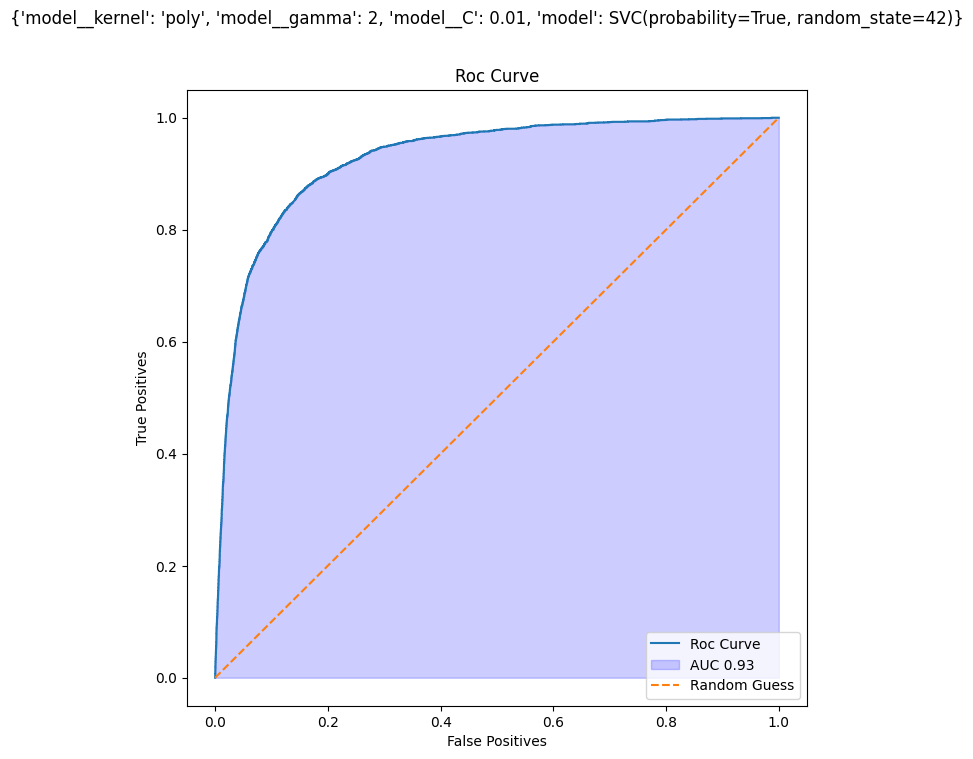

In [114]:
# getting probabilities of Explicit class
y_score = svm_grid.predict_proba(x_test)[:, 1]

# getting false positives, true positives and area under the curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)
_auc = auc(fpr, tpr)

# plotting the roc curve
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label='Roc Curve')
plt.fill_between(fpr, tpr, alpha=0.2, color='blue', label=f'AUC {_auc:.2f}')
plt.xlabel('False Positives')
plt.ylabel('True Positives')
plt.title('Roc Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.suptitle(svm_grid.best_params_)
plt.legend(loc='lower right')
plt.show()

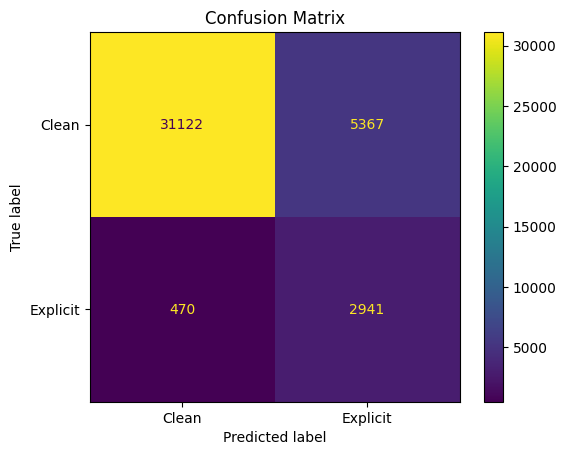

In [116]:
# getting the best threshold
J = tpr - fpr
idx = np.argmax(J)
best_threshold = thresholds[idx]
_y_pred = (y_score > best_threshold).astype(int)

# plotting the confusion matrix
cm = confusion_matrix(y_test, _y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Clean', 'Explicit'])
cm_display.plot()
plt.title('Confusion Matrix')
plt.show()